In [2]:
using Pkg

In [72]:
using ModelingToolkit, DifferentialEquations, Plots

@parameters σ ρ β
@variables t x(t) y(t) z(t)
D = Differential(t)

eqs = [D(x) ~ σ*(y-x),
       D(y) ~ x*(ρ-z)-y,
       D(z) ~ x*y - β*z];

@named de = ODESystem(eqs,t,[x,y,z],[σ,ρ,β],tspan=(0, 1000.0));
de=structural_simplify(de);

u0 = [x => 1,
       y => 1,
       z => 1]
#=
p = [σ => 0.1,
       ρ => 0.4,
       β => 0.4] 
=#

s = rand(Normal(0.1, 0.5), 1)[1]
pp, b = rand(Normal(0.4, 0.5), 2)

p = [σ => rand(Normal(0.1, 0.5), 1)[1],
       ρ => pp,
       β => b]       

vec = [[σ => s,
       ρ => pp,
       β => b] [σ => 1,
       ρ => 2,
       β => 3]]


3×2 Matrix{Pair{Num, Float64}}:
 σ=>0.00157204  σ=>1.0
 ρ=>0.554893    ρ=>2.0
 β=>0.176508    β=>3.0

Pair{Num, Float64}[σ => 0.09001626628624818, ρ => 1.124226097537347, β => -0.3799368102032038]

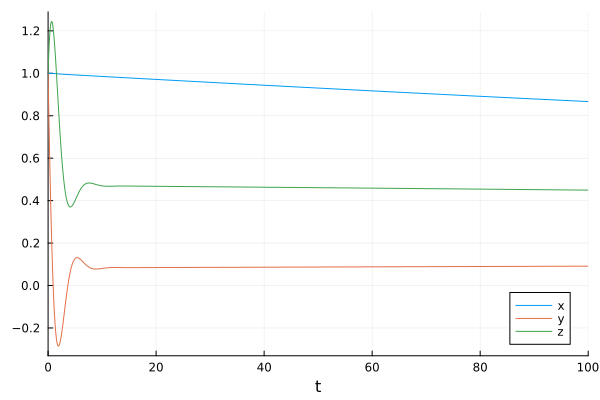

In [73]:
tspan = (0.0, 100);
prob = ODEProblem(de, u0, tspan, vec[:,1], jac = true);
sol = solve(prob);
plot(sol)

In [43]:
#using Pkg
#Pkg.add("Distributions")

using Random, Distributions

d = Normal(1,3);
x = rand(d, 1);
print(x)
fit(Normal, x);


[0.261265287483744]0.05

In [3]:
# test with parameters defined first
C_ATP = 1.85 #Biochem
C_ADP = 0.138 #Biochem
C_cit = 0.1
C_AMP = 3*10^-2 #Mulq
C_AMPK = 5*10^-5 
C_Pi = 1 #Biochem + Mulq
C_G6P = 8.3*10^-2 #Biochem
C_GAP = 1.9*10^-2 #Biochem 
C_DHAP = 1.38*10^-1 #Biochem

#=
Cons = [C_ATP => 1.59*10^-1, #Mulq
    C_MgATP => 1.52, #Mulq
    C_ADP => 9.37*10^-2, #Mulq
    C_MgADP => 0.11, #Mulq
    C_Mg => 0.4, #Mulq
    C_cit => 0.1,
    C_AMP => 3*10^-2, #Mulq
    C_Pi => 1, #Mulq
    C_G6P => 3.9*10^-2, #Mulq
    C_GAP => 5.7*10^-3  #Mulq
    ]    
=#
L_PFKM = 2*10^-3
L_PFK2 = 1*10^-3

Vf_GPI = 4.8*10^4
Vr_GPI = 40*10^4 
Vf_PFKM = 15.5*10^2
Vr_PFKM = 6.78*10^1
Vf_PFK2 = 41.6 
Vr_PFK2 = 30 #
Vf_FBP = 40 #
Vr_FBP = 30 #
Vf_ALD = 6.75*10^2
Vr_ALD = 2.32*10^3

Kf_GPI = 0.3
Kr_GPI = 0.123
Ki_ATP = 6.8*10^-2
Ki_cit = 0.1
Ka_f6p = 6*10^-2
Ka_f16bp = 0.65
Ka_AMP = 0.3
Ka_f26bp = 5.5*10^-3
K_f6p = 6*10^-2
K_ATP = 6.8*10^-2
K_f16bp = 0.65
K_ADP = 0.54
K_cat = 0.1
v_P = 0.005
K2_ATP = 0.15
K2_f6p = 0.032
K2_f26bp = 0.008
K2_ADP = 0.062
K_FBP_f26bp = 1*10^-3
K_FBP_f6p = 25*10^-3
K_Pi = 0.23 #
KAld_f16bp = 5*10^-2
K_GAP = 0.189
K_DHAP = 3.5*10^-2

0.035

In [5]:
    
using ModelingToolkit, DifferentialEquations
#=
@parameters C_ATP C_ADP C_cit C_AMP C_AMPK C_Pi C_G6P C_GAP C_DHAP # Concentrations 
@parameters L_PFKM L_PFK2 # L values
@parameters Vf_GPI Vr_GPI Vf_PFKM Vr_PFKM Vf_PFK2 Vr_PFK2 Vf_FBP Vr_FBP Vf_ALD Vr_ALD # V values. Vf are Vmax forward and Vr are Vmax reversed for each enzyme.

@parameters Kf_GPI Kr_GPI # For r_GPI
@parameters Ki_ATP Ki_cit Ka_f6p Ka_f16bp Ka_AMP Ka_f26bp # For N_PFKM Ki is inhibitors and Ka is activators
@parameters K_f6p K_ATP K_f16bp K_ADP # For r_PFKM
@parameters K_cat v_P # For psi
@parameters K2_ATP K2_f6p K2_f26bp K2_ADP # For r_PFK2. 2 refers to PFK2
@parameters K_FBP_f26bp K_FBP_f6p K_Pi # For r_FBP
@parameters KAld_f16bp K_GAP K_DHAP # For r_ALD
=#
@variables t f6p(t) f16bp(t) f26bp(t)
D = Differential(t)

r_GPI = (Vf_GPI*C_G6P/Kf_GPI - Vr_GPI*f6p/Kr_GPI)/
    (1 + C_G6P/Kf_GPI + f6p/Kr_GPI)

N_PFKM = 1 + L_PFKM*(1 + C_ATP/Ki_ATP)^4*(1 + C_cit/Ki_cit)^4/
    ((1 + f6p/Ka_f6p + f16bp/Ka_f16bp)^4 * (1 + C_AMP/Ka_AMP)^4 * (1 + f26bp/Ka_f26bp)^4)

r_PFKM = ((Vf_PFKM*C_ATP*f6p/(K_f6p*K_ATP) - Vr_PFKM*C_ADP*f16bp/(K_f16bp*K_ADP))/
    ((1 + f6p/K_f6p)*(1 + C_ATP/K_ATP) + (1 + f16bp/K_f16bp)*(1 + C_ADP/K_ADP) -1))*
    (1/N_PFKM)

psi = (K_cat*C_AMPK)/((K_cat*C_AMPK)+v_P)
N_PFK2 = 1 + L_PFK2*(psi/(1-psi))^2

r_PFK2 = ((Vf_PFK2*C_ATP*f6p)/(K2_ATP*K2_f6p) - (Vr_PFK2*C_ADP*f26bp)/(K2_f26bp*K2_ADP)) / 
    ((1+f6p/K2_f6p)*(1+C_ATP/K2_ATP) + (1+f26bp/K2_f26bp)*(1+C_ADP/K2_ADP) -1) *
    (1-(1/N_PFK2))

r_FBP = ((Vf_FBP*f26bp)/(K_FBP_f26bp) - (Vr_FBP*C_Pi*f6p)/(K_Pi*K_FBP_f6p))/
    ((1+f26bp/K_FBP_f26bp) + (1+f6p/K_FBP_f6p)*(1+C_Pi/K_Pi)-1) * 
    (1/N_PFK2)

r_ALD = ((Vf_ALD*f16bp)/(KAld_f16bp) - (Vr_ALD*C_GAP*C_DHAP)/(K_GAP*K_DHAP))/ 
    ((1 + f6p/KAld_f16bp) + (1 + C_GAP/K_GAP)*(1 + C_DHAP/K_DHAP) -1)

eqs = [D(f6p) ~ r_GPI - r_PFKM - r_PFK2 + r_FBP,
    D(f16bp) ~ r_PFKM - r_ALD,
    D(f26bp) ~ r_PFK2 - r_FBP]

@named sys = ODESystem(eqs, t)

sys=structural_simplify(sys)


Model sys with 3 equations
Unknowns (3):
  f6p(t)
  f16bp(t)
  f26bp(t)
Parameters (0):
Incidence matrix:3×6 SparseArrays.SparseMatrixCSC{Num, Int64} with 11 stored entries:
 ×  ×  ×  ×  ⋅  ⋅
 ×  ×  ×  ⋅  ×  ⋅
 ×  ⋅  ×  ⋅  ⋅  ×

In [9]:

u0 = [f6p => 1,
    f16bp => 0.01,
    f26bp => 0.01]


3-element Vector{Pair{Num, Float64}}:
   f6p(t) => 1.0
 f16bp(t) => 0.01
 f26bp(t) => 0.01

[0.0040835925053169875, 0.0681248522077272, 0.0005326425012831794]

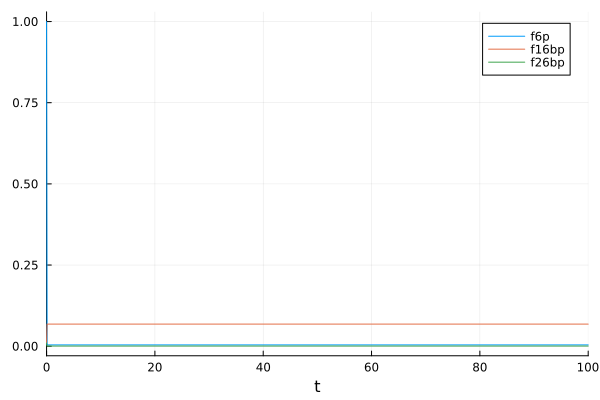

In [10]:
tspan = (0.0, 100)
prob = ODEProblem(sys, u0, tspan, jac = true)
sol = solve(prob)
print(sol[end])

using Plots
plot(sol)